# Coronavirus COVID-19

 * https://github.com/CSSEGISandData/COVID-19
 * http://covidtracking.com
 * https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

$$ \frac{dN}{dt}=k\ N\ (N_M - N);\quad N(0)=N_0  $$

$$ \frac{N(t)}{N_M}= \frac {F_0 e^{k N_Mt}}{1+F_0e^{k N_Mt}};\quad F_0=\frac{N_0}{N_M-N_0}  $$

In [1]:
%pylab inline
from datetime import datetime
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Populating the interactive namespace from numpy and matplotlib


### Moving average function
This is a *trailing* average based on [this conversation](https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy).

In [2]:
def moving_average(a, n=3, reverse=False) :
    
    if reverse: a=a[::-1]   # this is for cases where newer data is first in the list
        
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret = ret[n - 1:] / n
    ret = pad(ret,(n-1,0), 'constant')  
    
    if reverse: ret=ret[::-1]
    
    return ret

## Load data

In [3]:
#cases_url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
cases_url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
filename="/Users/scott/Downloads/time_series_19-covid-Confirmed-2.csv"
df=pd.read_csv(cases_url)

deaths_url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_D=pd.read_csv(deaths_url)

## US data

In [4]:
df_US=df[df['Country/Region']=='US'].copy()
df_it=df[df['Country/Region']=='Italy']
df_US

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358


In [5]:
date_string=df_US.columns[5:]
dates=[ datetime.strptime(str(d), '%m/%d/%y') for d in date_string ]        

N_US=array(df_US.iloc[0,5:])

In [6]:
dN_US = diff(N_US)
dN_US = pad(dN_US,(1,0), 'constant') 

## Michigan data

In [7]:
url_states="http://covidtracking.com/api/states/daily.csv"
df_states=pd.read_csv(url_states)
df_MI=df_states[df_states['state']=='MI'].copy()
df_MI.loc[isnan(df_MI['death']),'death']=0

In [8]:
date_MI= array(df_MI['date'])
date_MI=[ datetime.strptime(str(d), '%Y%m%d') for d in date_MI ]   

N_MI= array(df_MI['positive']+df_MI['death'])

In [9]:
dN_MI = -diff(N_MI)
dN_MI = pad(dN_MI,(0,1), 'constant')  

## Linear Plot

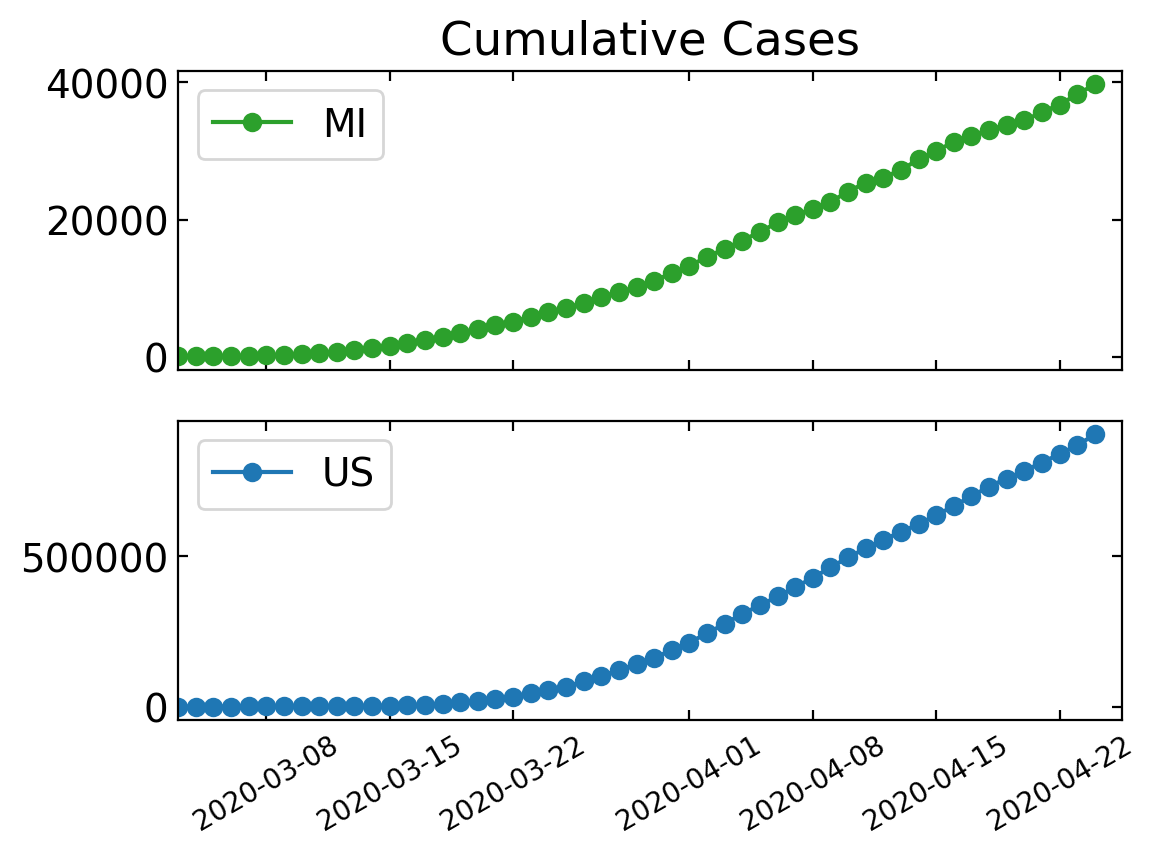

In [10]:
dstart = datetime(2020,3,3)

fig,ax=subplots(2,1, sharex=True)

sca(ax[0])
plot_date(date_MI,N_MI,'-o',c='C2')
legend(['MI'], loc=2)
title('Cumulative Cases')

sca(ax[1])
plot_date(dates,N_US,'-o')
xlim(dstart, datetime.now())  
ax[1].xaxis.set_tick_params(rotation=30, labelsize=10)
legend(['US'])

tight_layout()
show()

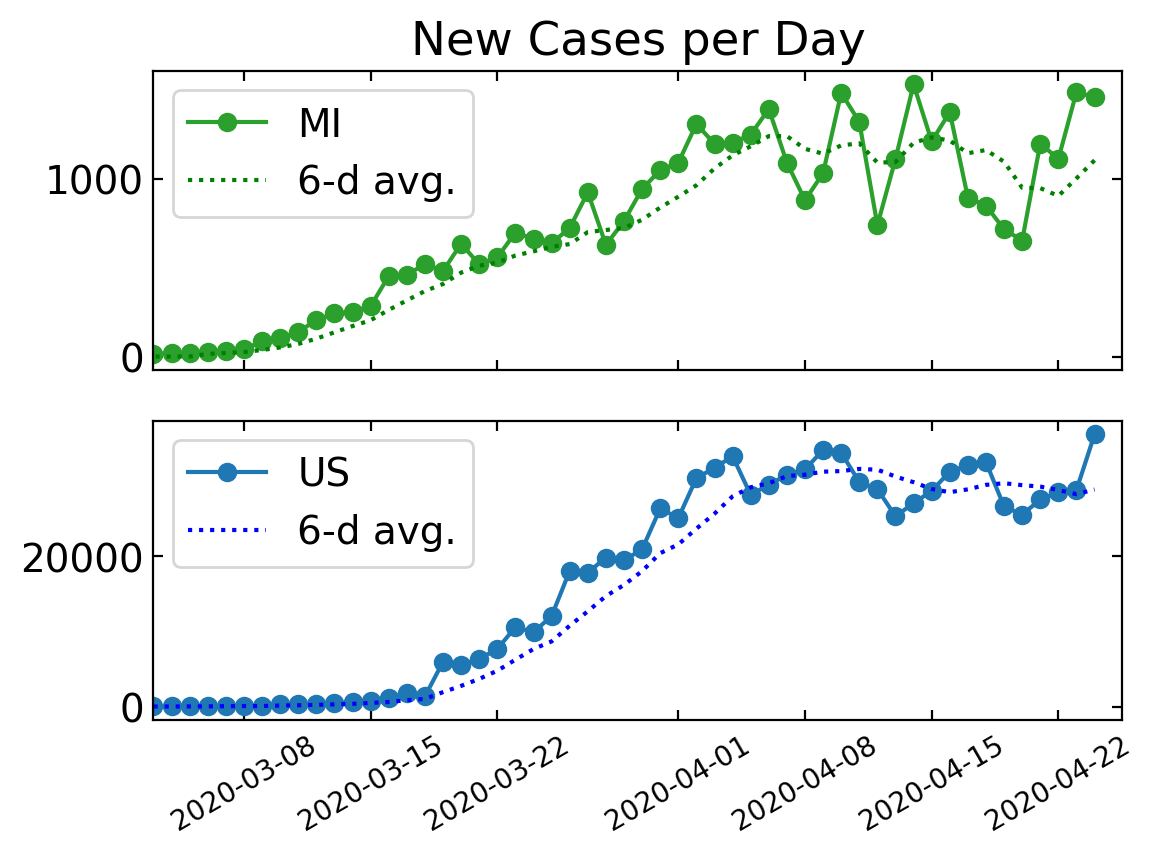

In [11]:
dstart = datetime(2020,3,3)
n=6  # average over n days

fig,ax=subplots(2,1, sharex=True)

sca(ax[0])
plot_date(date_MI,dN_MI,'-o',c='C2')
plot_date(date_MI, moving_average(dN_MI,n, reverse=True), ':', c='green')
legend(['MI', f'{n}-d avg.'], loc=2)
title('New Cases per Day')

sca(ax[1])
plot_date(dates,dN_US,'-o')
plot_date(dates, moving_average(dN_US,n), ':', c='blue')
xlim(dstart, datetime.now())  
ax[1].xaxis.set_tick_params(rotation=30, labelsize=10)
legend(['US',f'{n}-d avg.'])

tight_layout()
show()

## Log plot

In [12]:
days=13
N=array(N_US,dtype=float)[-days:]

In [13]:
# We might use a linear function here to avoid weighting the larger, later values more
# than the earlier, smaller values
def fitfun(t,a,k):
    return a*exp(k*t)
    #return a + k*t

p,Cov =curve_fit(fitfun, arange(len(N)), N)
p

array([5.66074172e+05, 3.98391514e-02])

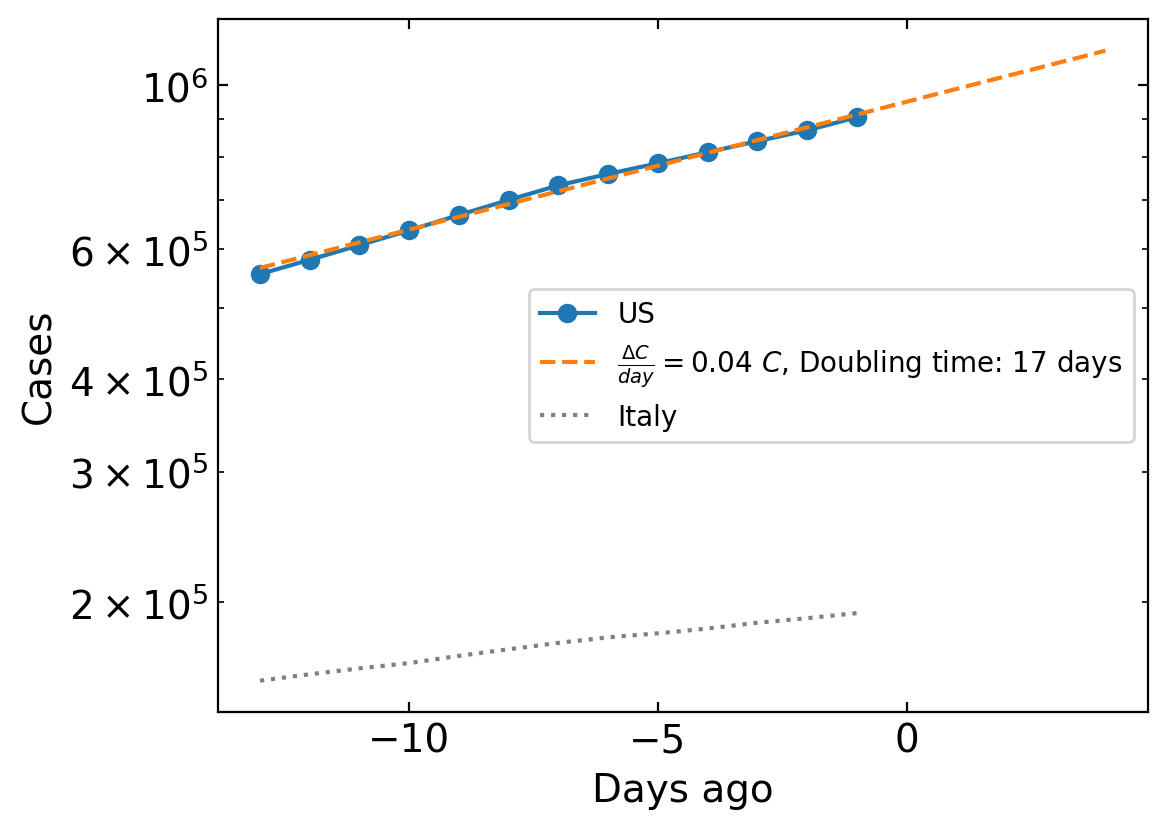

In [14]:
xfit=arange(len(N)+5)
Nfit=fitfun(xfit,*p)

x=arange(len(N))-days
semilogy(x,N,'-o',xfit-days,Nfit,'--')

Nit=array(df_it.iloc[0,-days:])
semilogy(x.T,Nit,':',color='gray')

xlabel('Days ago')
ylabel('Cases')
fitleg=r'$\frac{\Delta C}{day}=' + f'{p[1]:.2g}' + '\ C $,' \
    + f' Doubling time: {log(2)/p[1]:.2g} days'
legend(['US', fitleg, 'Italy'], fontsize=10)
show()

In [15]:
f'Tenfold time: {log(10)/p[1]:.2g} days'

'Tenfold time: 58 days'

## Deaths per Day

### US

In [16]:
D_US=df_D[df_D['Country/Region']=='US'].iloc[0,5:]
D_US=array(D_US)
dD_US=diff(D_US[D_US>=10])

x_US=arange(len(dD_US))
dD_US_avg = moving_average(dD_US, n)

#### Italy 

In [17]:
D_it=df_D[df_D['Country/Region']=='Italy'].iloc[:,5:]
D_it=array(D_it)[0]
dD_it=diff(D_it[D_it>=10])

x_it=arange(len(dD_it))

### MI

In [18]:
D_MI=array(df_MI['death'])
D_MI=D_MI[::-1] # reverse the  array
dD_MI=diff(D_MI[D_MI>=10])

x_MI=arange(len(dD_MI))
dD_MI_avg = moving_average(dD_MI, n)

### Plot

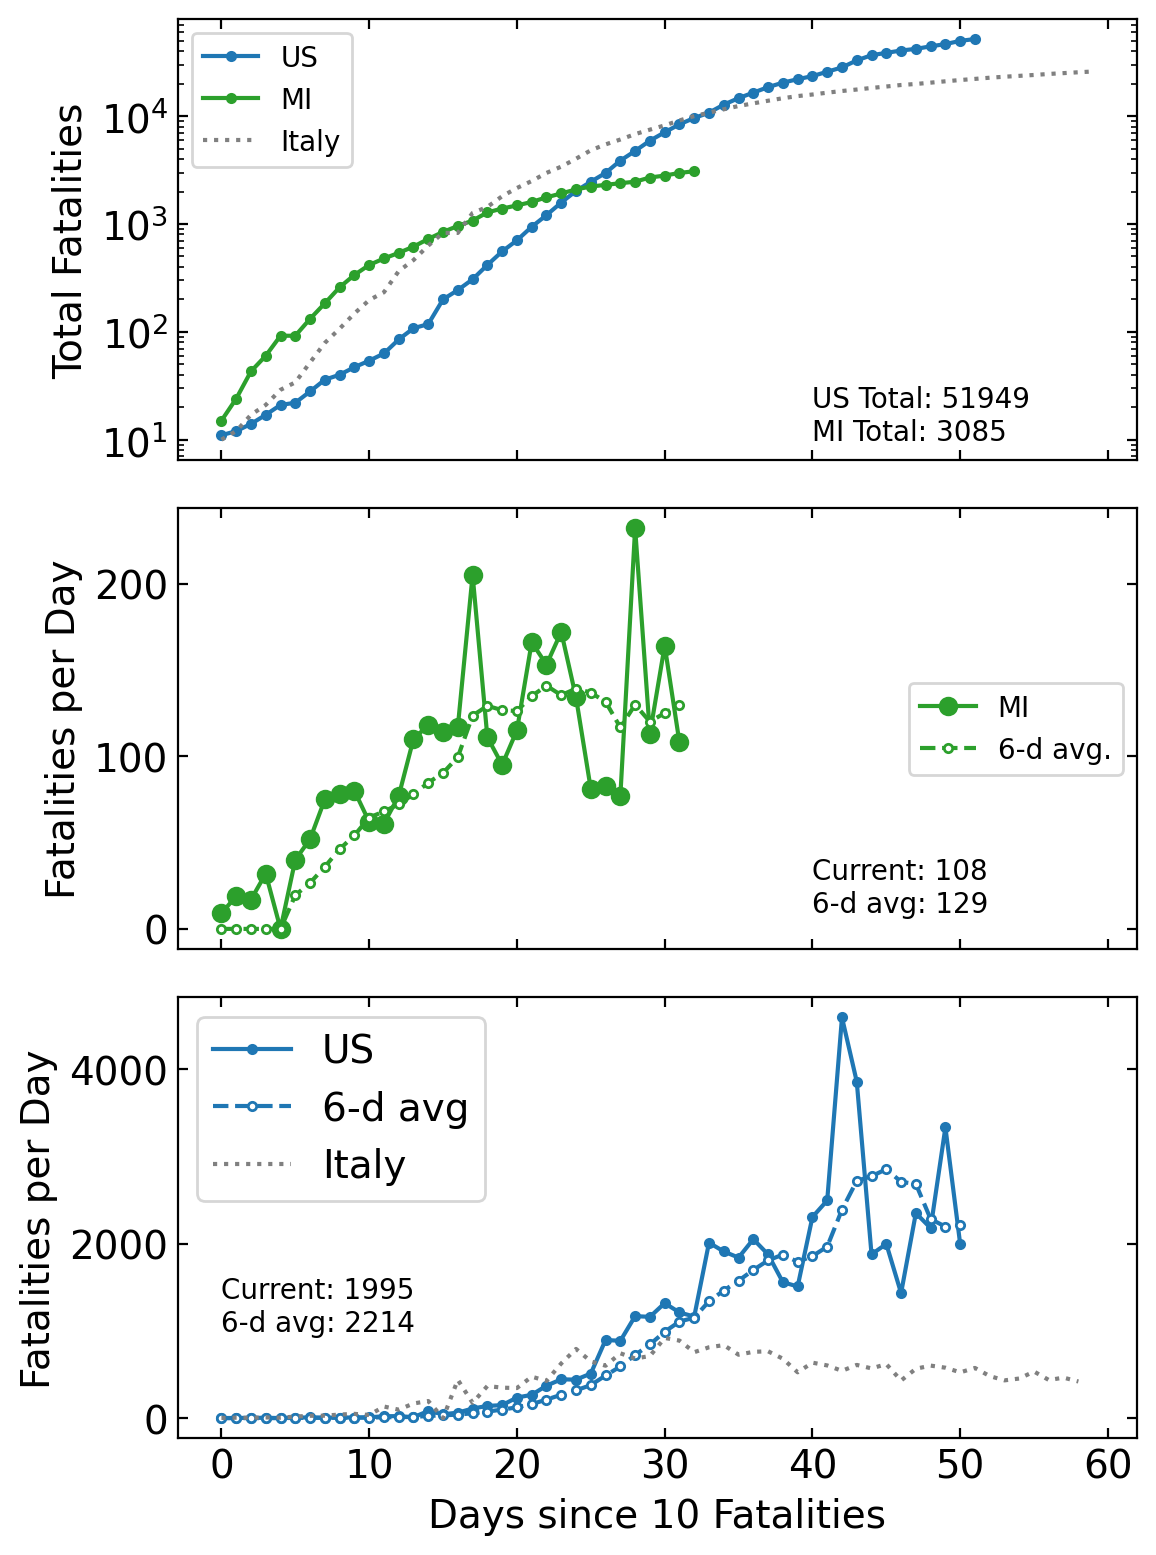

In [19]:
fig,ax=subplots(3,1,figsize=[6,8], sharex=True)

sca(ax[0])
semilogy(D_US[D_US>=10],marker='.',label='US')
semilogy(D_MI[D_MI>=10],marker='.',c='C2',label='MI')
semilogy(D_it[D_it>=10],':',c='gray',label='Italy')

ylabel('Total Fatalities')
legend(fontsize=10)
dstr=f'US Total: {D_US[-1]} \nMI Total: {int(D_MI[-1])}'
text(40,10,dstr,fontsize=10)

sca(ax[1])
plot(x_MI,dD_MI,marker='o',c='C2',label='MI')
plot(x_MI, dD_MI_avg ,'--', marker='.', mfc='white', c='C2',label=f'{n}-d avg')
ylabel('Fatalities per Day')
legend(['MI', f'{n}-d avg.'], loc=5, fontsize=10)
dstr=f'Current: {int(dD_MI[-1])} \n{n}-d avg: {int(dD_MI_avg[-1])}'
text(40,10,dstr,fontsize=10)


sca(ax[2])
plot(x_US,dD_US,marker='.',label='US')
plot(x_US, dD_US_avg,'--', marker='.', mfc='white', c='C0',label=f'{n}-d avg')
plot(x_it,dD_it,':',c='gray',label='Italy')

xlabel('Days since 10 Fatalities')
ylabel('Fatalities per Day')
legend()
dstr=f'Current: {int(dD_US[-1])} \n{n}-d avg: {int(dD_US_avg[-1])}'
text(0,1000,dstr,fontsize=10)

tight_layout()
show()

## Fit to Fatality Data

$$ \frac{N(t)}{N_M}= \frac {F_0 e^{k N_Mt}}{1+F_0e^{k N_Mt}};\quad F_0=\frac{N_0}{N_M-N_0}  $$

In [20]:
def fatfun(t,k,NM):
    N0 = 10
    F0 = N0 / (NM - N0)
    
    N=NM*F0*exp(k*NM*t) / (1 + F0*exp(k*NM*t))
    return array(N)

In [21]:
y=D_it[D_it>=10]
x=arange(len(y))

pguess=[0.0001,100000]
p,Cov =curve_fit(fatfun, x, y, pguess)
perr=sqrt(diag(Cov))
print(f'k = {p[0]:.4g} ± {perr[0]:.4g}')
print(f'N_M = {p[1]:.4g} ± {perr[1]:.4g}')

k = 9.987e-06 ± 2.55e-07
N_M = 2.263e+04 ± 410.6


$$ \frac{dN}{dt}=k\ N\ (N_M - N) = k N_m^2 \left[\frac{F_0 e^{k N_M t}}{\left( 1 + F_0 e^{k N_M t}\right)^2}\right]  $$

In [22]:
def dfatfun(t,k,NM):
    N0 = 10
    F0 = N0 / (NM - N0)
    
    return k * NM**2 * F0 * exp(k*NM*t) / (1 + F0*exp(k*NM*t))**2

In [23]:
pguess=[1e-5,1e4]
pd,Cov =curve_fit(dfatfun, x_it, dD_it, pguess)
pderr=sqrt(diag(Cov))
print(f'k = {pd[0]:.4g} ± {pderr[0]:.4g}')
print(f'N_M = {pd[1]:.4g} ± {pderr[1]:.4g}')

k = 1.167e-05 ± 7.692e-07
N_M = 1.814e+04 ± 1238


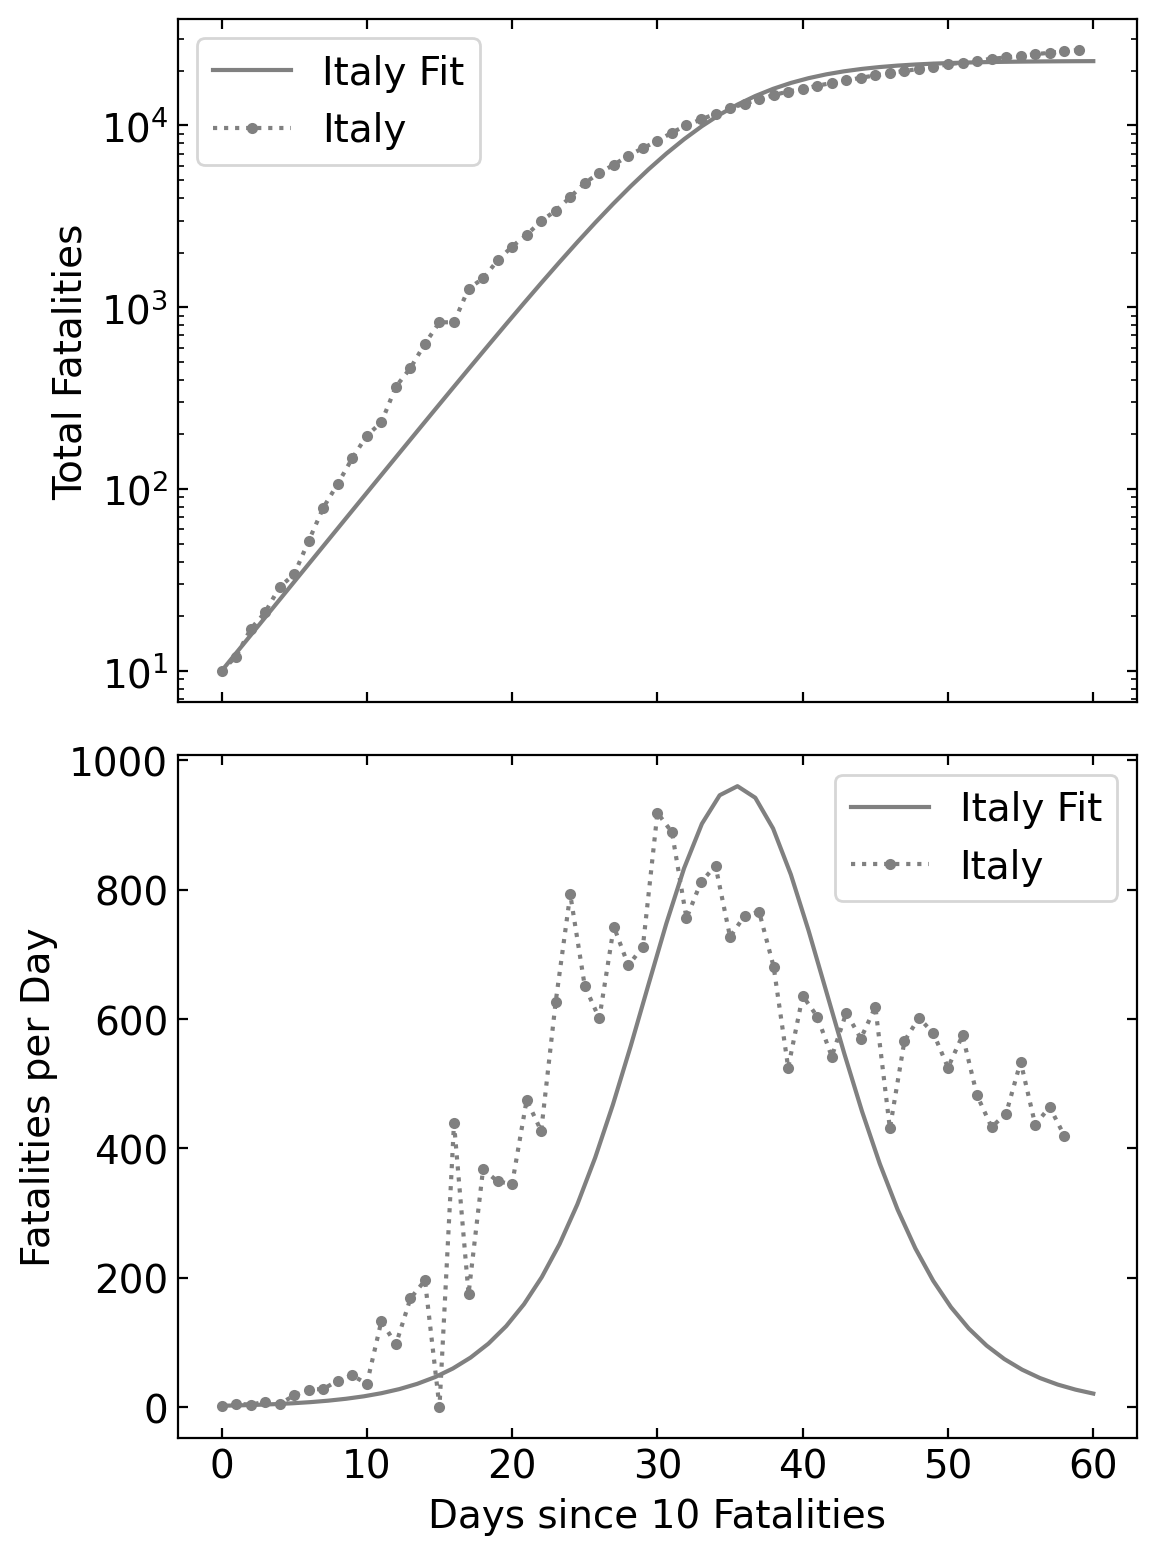

In [24]:
xfit=linspace(0,60)

fig,ax=subplots(2,1,figsize=[6,8], sharex=True)

sca(ax[0])
semilogy(xfit,fatfun(xfit,*p),c='gray',label='Italy Fit',zorder=-1)
semilogy(D_it[D_it>=10],':.',c='gray',label='Italy')

ylabel('Total Fatalities')
legend()

sca(ax[1])
plot(xfit,dfatfun(xfit,*pd),c='gray',label='Italy Fit', zorder=1)
plot(x_it,dD_it,':.',c='gray',label='Italy')

xlabel('Days since 10 Fatalities')
ylabel('Fatalities per Day')
legend()

tight_layout()
show()

In [25]:
k, NM=p
F0= 10/(10+NM)
tau=log(99/F0)/k/NM
tau, fatfun(tau,*p)/NM

(54.50276835629997, 0.9900087442778427)